In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
from gurobipy import *

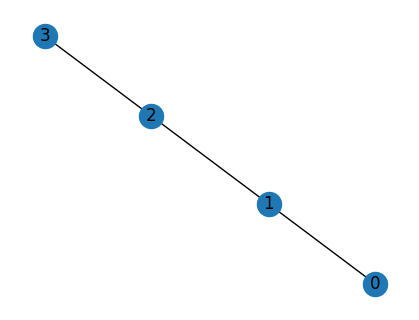

In [2]:
# network graph
N = 4# number of nodes
node_list = np.arange(N)
G = nx.Graph()
G.add_nodes_from(node_list)
p = 0.4
q = 0.5
# adj_mat = np.diag(np.ones(N-1),1)
adj_mat = np.zeros((N,N))
for n in range(N-1):
    adj_mat[n,n+1] = p
# adj_mat[1,2] = 200
# adj_mat[0,4] = p
# adj_mat[3,4] = p
# adj_mat[1,2] = p
adj_mat += adj_mat.T
G = nx.from_numpy_array(adj_mat)
# G.add_edges_from([(q,q+1) for q in range(N-1)])
plt.figure(figsize=(4,3))
nx.draw(G,  with_labels=True)
plt.show()

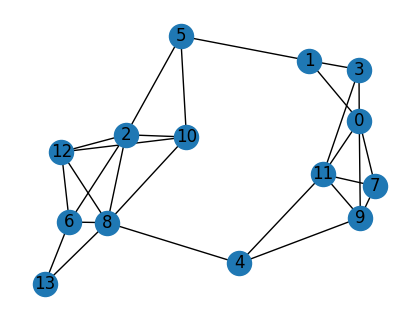

In [6]:
# random network graph
N = 14# number of nodes
node_list = np.arange(N)

# p = 0.5
length = 1
width = 1
dmax = 0.4
# np.random.seed = 3
random.seed(20)
pos = dict()
for node in range(N):
    pos[node] = (random.random()*length,random.random()*width)
    
# # adj_mat = np.zeros((N,N))
# # for i in range(N):
# #     adj_mat[i,i+1:] = np.random.rand(N-i-1)< p*np.exp(-())
    
# # adj_mat += adj_mat.T
# # G= nx.from_numpy_array(adj_mat)

# # G = nx.waxman_graph(N, beta=0.4, alpha=0.1, L=1, domain=(0, 0, 1, 1))#, metric=None, seed=None
# # dist = lambda x, y: sum(abs(a - b) for a, b in zip(x, y))
# # G = nx.waxman_graph(N, 1, 0.15, L = .5)#, metric=dist)

G = nx.random_geometric_graph(N, dmax, dim=2, pos=pos, p=2)
# G = nx.Graph()
# G.add_nodes_from(range(N))
# nx.set_node_attributes(G, pos = pos)
# pos = nx.get_node_attributes(G, 'pos')
weights = dict()
for e in G.edges():
    weights[e] = np.linalg.norm([pos[e[0]][0]-pos[e[1]][0],pos[e[0]][1]-pos[e[1]][1]])
    
nx.set_edge_attributes(G, values = weights, name = 'weight')

plt.figure(figsize=(4,3))
nx.draw(G,pos,with_labels=True)
plt.show()

# for node in G.nodes():
#     print(node)
# print(G.pos())

# p0to3 = nx.shortest_path(G, source=0, target=3, weight="weight")
# length = nx.shortest_path_length(G, source=0, target=3, weight="weight")

# print(p0to3,length)

In [39]:
Nmax = 10
Lmax = 0.4
D0 = 2
D = D0*np.ones(N)
s_list = [13,12,10] # source
t_list = [9,11,7] # destination
C = len(s_list)

# indices: (superscript, subscript)
m = Model()
x = m.addMVar((C,N,N), vtype=GRB.BINARY,name="x")
yu = m.addMVar((N), vtype=GRB.BINARY,name="yu")
# yu = m.addMVar((N), vtype=GRB.INTEGER,name="yu")

R_list = np.array(list(set(node_list)-set(np.concatenate((s_list,t_list)))))

path_length = 0
for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]
    
#     R_list = list(set(node_list)-{s,t})
#     R = len(R_list)
#     y_sum = 0
    number = 0
    path_s = x[user_pair][s][t]
    path_t = x[user_pair][s][t]
    for n1 in R_list:
        if nx.has_path(G, source=s, target=n1):
            l_uv = nx.shortest_path_length(G, source=s, target=n1, weight="weight")
            m.addConstr( l_uv*x[user_pair][s][n1] <= Lmax ) 
            path_length += l_uv*x[user_pair][s][n1]
        else:
            m.addConstr( x[user_pair][s][n1] == 0 ) 
            
        if nx.has_path(G, source=n1, target=t):
            l_uv = nx.shortest_path_length(G, source=n1, target=t, weight="weight")
            m.addConstr( l_uv*x[user_pair][n1][t] <= Lmax ) 
            path_length += l_uv*x[user_pair][n1][t]
        else:
            m.addConstr( x[user_pair][n1][t] == 0 ) 
#         y_sum += yu[n1]
#         y_const = x[user_pair][n1][t]
        path = x[user_pair][n1][t] - x[user_pair][s][n1]
        number += x[user_pair][s][n1]+ x[user_pair][n1][t]
        path_s += x[user_pair][s][n1]
        path_t += x[user_pair][n1][t]
        for n2 in R_list:
            if n2 != n1:
                if nx.has_path(G, source=n1, target=n2):
                    l_uv = nx.shortest_path_length(G, source=n1, target=n2, weight="weight")
                    m.addConstr( l_uv*x[user_pair][n1][n2] <= Lmax ) 
                    path_length += l_uv*x[user_pair][n1][n2]
                else:
                    m.addConstr( x[user_pair][n1][n2] == 0 ) 
                    
                path += x[user_pair][n1][n2] - x[user_pair][n2][n1]
                number += x[user_pair][n1][n2]
#                 y_const += x[user_pair][n1][n2]

#         m.addConstr( y_const <= D[n1]*yu[n1] ) 
        m.addConstr( path == 0 ) 
    m.addConstr( number <= Nmax + 1 ) 
    m.addConstr( path_s == 1 )
    m.addConstr( path_t == 1 )
    m.addConstr( nx.shortest_path_length(G, source=s, target=t, weight="weight")*x[user_pair][s][t] <= Lmax ) 

# R_list = list(set(node_list)-set(np.concatenate((s_list,t_list))))

# y_const = np.zeros(len(R_list))
    
for n1 in R_list:
    y_const = 0
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]
        y_const += x[user_pair][n1][t]
        for n2 in R_list:
            if n2 != n1:
                y_const += x[user_pair][n1][n2]

    m.addConstr( y_const <= D[n1]*yu[n1] ) 
#     m.addConstr( y_const <= yu[n1] ) 


y_sum = 0
for n1 in range(N):
    m.addConstr( yu[n1] <= D0) 
    m.addConstr( 0 <= yu[n1] ) 
    if (n1 not in s_list) and (n1 not in t_list):
        y_sum += yu[n1]

α = 0./C
m.setObjective(y_sum+ α*path_length , GRB.MINIMIZE)
m.optimize()

x_size = C*N**2 + N
x0 = np.zeros((C,N,N))
y0 = np.zeros(N)
for i in range(N):
    if m.getVars()[len(s_list)*N**2+i].X > 0:
        y0[i] = m.getVars()[len(s_list)*N**2+i].X
    for j in range(N):
        for user_pair in range(C):
            if m.getVars()[user_pair*N**2+i*N+j].X > 0:
                x0[user_pair,i,j] = m.getVars()[user_pair*N**2+i*N+j].X


Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 288 rows, 602 columns and 1101 nonzeros
Model fingerprint: 0xc8068b8b
Variable types: 0 continuous, 602 integer (602 binary)
Coefficient statistics:
  Matrix range     [1e-01, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-01, 1e+01]
Presolve removed 262 rows and 555 columns
Presolve time: 0.00s
Presolved: 26 rows, 47 columns, 161 nonzeros
Variable types: 0 continuous, 47 integer (47 binary)
Found heuristic solution: objective 7.0000000
Found heuristic solution: objective 5.0000000

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 12 (of 12 available processors)

Solution count 2: 5 7 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.000000000000e+00, best bound 5.00000

[1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
(13, 9) : [array([4, 9]), array([8, 4]), array([13,  8])]
(12, 11) : [array([ 4, 11]), array([8, 4]), array([12,  8])]
(10, 7) : [array([0, 7]), array([1, 0]), array([5, 1]), array([10,  5])]


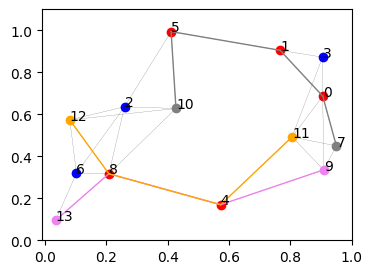

In [40]:
print(y0)
plt.figure(figsize=(4,3))
# nx.draw(Gopt, pos, with_labels=True)
for i,y_val in enumerate(y0):
    if i not in np.concatenate((s_list,t_list)):
        if y_val >= 1:
            plt.plot(pos[i][0],pos[i][1],"ro")#,markersize=5)
#             plt.text(pos[i][0],pos[i][1],"%d,%d" % (i,y_val))
            plt.text(pos[i][0],pos[i][1],"%d" % i)
        else:
            plt.plot(pos[i][0],pos[i][1],"bo")
            plt.text(pos[i][0],pos[i][1],"%d" % i)
     
for e in G.edges():
    plt.plot([ pos[e[0]][0],pos[e[1]][0] ], [ pos[e[0]][1],pos[e[1]][1] ], color = "black", linewidth=0.1)

colors = ["violet","orange","gray"]
for user_pair in range(C):
    s = s_list[user_pair]
    plt.plot(pos[s][0],pos[s][1],"o", color = colors[user_pair])
    plt.text(pos[s][0],pos[s][1],"%d" % s)
    t = t_list[user_pair]
    plt.plot(pos[t][0],pos[t][1],"o", color = colors[user_pair])
    plt.text(pos[t][0],pos[t][1],"%d" % t)

    edges = np.argwhere(x0[user_pair,:,:]>0)
    path_output = []
    for e in edges:
        if G.has_edge(e[0],e[1]):
            plt.plot([ pos[e[0]][0],pos[e[1]][0] ], [ pos[e[0]][1],pos[e[1]][1] ], color = colors[user_pair], linewidth=1)
            path_output.append(e)
        else:
            path = nx.shortest_path(G, source=e[0], target=e[1], weight="weight")
            path_output.append(path)
            for i in range(len(path)-1):
                e1 = path[i]
                e2 = path[i+1]
                plt.plot([ pos[e1][0],pos[e2][0] ], [ pos[e1][1],pos[e2][1] ], color = colors[user_pair], linewidth=1)
                
    print((s_list[user_pair],t_list[user_pair]),":",path_output)
plt.xlim([-0.01,1])
plt.ylim([0,1.1])
plt.show()


(10, 11) : [[2, 7, 3], [3, 18, 5], array([ 5, 11]), [10, 16, 2]]
(4, 19) : [[2, 7, 3], [3, 18, 5], [4, 15, 12], [5, 1, 19], array([12,  2])]
(17, 9) : [[2, 7, 3], [3, 18, 5], [5, 1, 9], array([12,  2]), [17, 15, 12]]


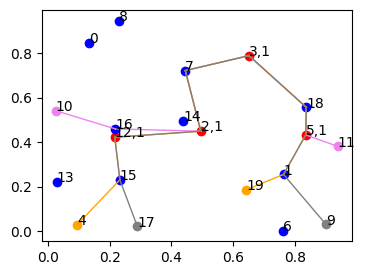

In [65]:

plt.figure(figsize=(4,3))
# nx.draw(Gopt, pos, with_labels=True)
for i,y_val in enumerate(y0):
    if i not in np.concatenate((s_list,t_list)):
        if y_val >= 1:
            plt.plot(pos[i][0],pos[i][1],"ro")#,markersize=5)
            plt.text(pos[i][0],pos[i][1],"%d,%d" % (i,y_val))
        else:
            plt.plot(pos[i][0],pos[i][1],"bo")
            plt.text(pos[i][0],pos[i][1],"%d" % i)
            
colors = ["violet","orange","gray"]
for user_pair in range(C):
    s = s_list[user_pair]
    plt.plot(pos[s][0],pos[s][1],"o", color = colors[user_pair])
    plt.text(pos[s][0],pos[s][1],"%d" % s)
    t = t_list[user_pair]
    plt.plot(pos[t][0],pos[t][1],"o", color = colors[user_pair])
    plt.text(pos[t][0],pos[t][1],"%d" % t)

    edges = np.argwhere(x0[user_pair,:,:]>0)
    path_output = []
    for e in edges:
        if G.has_edge(e[0],e[1]):
            plt.plot([ pos[e[0]][0],pos[e[1]][0] ], [ pos[e[0]][1],pos[e[1]][1] ], color = colors[user_pair], linewidth=1)
            path_output.append(e)
        else:
            path = nx.shortest_path(G, source=e[0], target=e[1], weight="weight")
            path_output.append(path)
            for i in range(len(path)-1):
                e1 = path[i]
                e2 = path[i+1]
                plt.plot([ pos[e1][0],pos[e2][0] ], [ pos[e1][1],pos[e2][1] ], color = colors[user_pair], linewidth=1)
                
    print((s_list[user_pair],t_list[user_pair]),":",path_output)
plt.show()


In [310]:
Nmax = 10
Lmax = 0.5
D0 = 2
D = D0*np.ones(N)
s_list = [2,9] # source
t_list = [3,8] # destination

C = len(s_list)
R_list = np.array(list(set(node_list)-set(np.concatenate((s_list,t_list)))))

from gekko import GEKKO
m = GEKKO()#remote=False)

x = m.Array(m.Var,C* N**2,integer=True,lb=0,ub=1)
y = m.Array(m.Var,N ,integer=True,lb=0,ub=1)

# x = np.array([None]*C* N**2)
# y = np.array([None]*N)
# for i in range(N):
#     y[i] = m.Var(y0[i],lb=0,ub=1,integer=True)
#     for j in range(N):
#         for user_pair in range(C):
#             x[user_pair*N**2+i*N+j] = m.Var(x0[user_pair,i,j].astype(int),lb=0,ub=1,integer=True)

# for i, xi in enumerate(x):
#     xi.value = x0[i]
# for i, yi in enumerate(y):
#     yi.value = y0[i]

# for r in np.concatenate((s_list,t_list)):
#     m.Equation( y[r]==0 )

for n1 in R_list:
    n_list = np.array(list(set(R_list)-{n1}))
    sum1_const = 0 
#     sum2_const = 0 
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]
        sum1_const += x[user_pair*N**2+n1*N+t] + np.sum(x[user_pair*N**2+n1*N+n_list])
#         sum2_const += x[user_pair*N**2+s*N+n1] + np.sum(x[user_pair*N**2+n_list*N+n1])
    m.Equation( sum1_const <= D[n1]*y[n1] )
#     m.Equation( sum2_const <= D[n1]*y[n1] )

# path_length = 0
for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]
    m.Equation( nx.shortest_path_length(G, source=s, target=t, weight="weight")*x[user_pair*N**2+s*N+t] <= Lmax)    
    
    number = np.sum(x[user_pair*N**2+s*N+R_list]+ x[user_pair*N**2+R_list*N+t])
    for n1 in R_list:
        m.Equation( x[user_pair*N**2+n1*N+n1] == 0)    
#         m.Equation( x[user_pair*N**2+n1*N+s] == 0)    
#         m.Equation( x[user_pair*N**2+t*N+n1] == 0)    
        if nx.has_path(G, source=s, target=n1):
            l_uv = nx.shortest_path_length(G, source=s, target=n1, weight="weight")
            m.Equation( l_uv*x[user_pair*N**2+s*N+n1] <= Lmax)
#             path_length += l_uv*x[user_pair*N**2+s*N+n1]
        else:
            m.Equation( x[user_pair*N**2+s*N+n1] == 0 ) 

        if nx.has_path(G, source=n1, target=t):
            l_uv = nx.shortest_path_length(G, source=n1, target=t, weight="weight")
            m.Equation( l_uv*x[user_pair*N**2+n1*N+t] <= Lmax)        
#             path_length += l_uv*x[user_pair*N**2+n1*N+t]
        else:
            m.Equation( x[user_pair*N**2+n1*N+t] == 0 ) 

        for n2 in R_list:
            if n2 != n1:
                if nx.has_path(G, source=n1, target=n2):
                    l_uv = nx.shortest_path_length(G, source=n1, target=n2, weight="weight")
                    m.Equation( l_uv*x[user_pair*N**2+n1*N+n2] <= Lmax)
#                     path_length += l_uv*x[user_pair*N**2+n1*N+n2]
                else:
                    m.Equation( x[user_pair*N**2+n1*N+n2] == 0 ) 

                
        n_list = np.array(list(set(R_list)-{n1}))
        m.Equation( x[user_pair*N**2+n1*N+t] - x[user_pair*N**2+s*N+n1] + np.sum(x[user_pair*N**2+n1*N+n_list] - x[user_pair*N**2+n_list*N+n1]) == 0)
        number += np.sum(x[user_pair*N**2+n1*N+n_list])

    m.Equation( number <= Nmax + 1)
    m.Equation( x[user_pair*N**2+s*N+t] + np.sum(x[user_pair*N**2+s*N+R_list]) == 1)
    m.Equation( x[user_pair*N**2+s*N+t] + np.sum(x[user_pair*N**2+R_list*N+t]) == 1)
             
α = 0.5/C
m.Minimize(np.sum(y) )
m.options.LINEAR = 1
m.options.SOLVER = 1
# m.options.solver = 3
# m.options.IMODE = 3
m.solver_options = ['minlp_maximum_iterations 100000']#'minlp_gap_tol 0.5', 'minlp_integer_tol 0.06']
# # optional solver settings with APOPT
# m.solver_options = ['minlp_maximum_iterations 500', \
#                     # minlp iterations with integer solution
#                     'minlp_max_iter_with_int_sol 20', \
#                     # treat minlp as nlp
#                     'minlp_as_nlp 0', \
#                     # nlp sub-problem max iterations
#                     'nlp_maximum_iterations 50', \
#                     # 1 = depth first, 2 = breadth first
#                     'minlp_branch_method 1', \
#                     # maximum deviation from whole number
#                     'minlp_integer_tol 0.05', \
#                     # covergence tolerance
#                     'minlp_gap_tol 0.01']
m.solve()

# print('y: ', y)
x_opt = np.zeros((C,N,N))
for i in range(N):
    for j in range(N):
        for user_pair in range(C):
            x_opt[user_pair,i,j] = x[user_pair*N**2+i*N+j][0]
# print("x: ", x_opt)


apm 128.107.241.181_gk_model87 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :          304
   Intermediates:            0
   Connections  :            0
   Equations    :          123
   Residuals    :          123
 
 Number of state variables:            304
 Number of total equations: -          122
 Number of slack variables: -           94
 ---------------------------------------
 Degrees of freedom       :             88
 
 ----------------------------------------------
 Steady State Optimization with APOPT Solver
 ----------------------------------------------
Iter:     1 I:  0 Tm:      0.00 NLPi:    0 Dpth:    0 Lvs:    3 Obj:  4.78E-01 Gap:       NaN
Iter:     2 I: -1 Tm:      0.00 N

Iter:   108 I: -1 Tm:      0.00 NLPi:    0 Dpth:   12 Lvs:   32 Obj:  1.85E+00 Gap:       NaN
Iter:   109 I: -1 Tm:      0.00 NLPi:    0 Dpth:   12 Lvs:   31 Obj:  1.85E+00 Gap:       NaN
Iter:   110 I:  0 Tm:      0.00 NLPi:    0 Dpth:   12 Lvs:   33 Obj:  2.16E+00 Gap:       NaN
Iter:   111 I: -1 Tm:      0.00 NLPi:    0 Dpth:   13 Lvs:   32 Obj:  2.00E+00 Gap:       NaN
Iter:   112 I:  0 Tm:      0.00 NLPi:    0 Dpth:   13 Lvs:   34 Obj:  2.00E+00 Gap:       NaN
Iter:   113 I: -1 Tm:      0.00 NLPi:    0 Dpth:   14 Lvs:   33 Obj:  2.00E+00 Gap:       NaN
Iter:   114 I:  0 Tm:      0.00 NLPi:    0 Dpth:   14 Lvs:   35 Obj:  2.28E+00 Gap:       NaN
Iter:   115 I:  0 Tm:      0.00 NLPi:    0 Dpth:   14 Lvs:   37 Obj:  2.03E+00 Gap:       NaN
Iter:   116 I:  0 Tm:      0.00 NLPi:    0 Dpth:   13 Lvs:   39 Obj:  2.00E+00 Gap:       NaN
Iter:   117 I: -1 Tm:      0.00 NLPi:    0 Dpth:    8 Lvs:   38 Obj:  2.00E+00 Gap:       NaN
Iter:   118 I: -1 Tm:      0.00 NLPi:    0 Dpth:    8 Lvs:  

Iter:   212 I: -1 Tm:      0.00 NLPi:    0 Dpth:   10 Lvs:   80 Obj:  2.15E+00 Gap:       NaN
Iter:   213 I: -1 Tm:      0.00 NLPi:    0 Dpth:   10 Lvs:   79 Obj:  2.15E+00 Gap:       NaN
Iter:   214 I:  0 Tm:      0.00 NLPi:    0 Dpth:   10 Lvs:   81 Obj:  2.23E+00 Gap:       NaN
Iter:   215 I: -1 Tm:      0.00 NLPi:    0 Dpth:   10 Lvs:   80 Obj:  2.15E+00 Gap:       NaN
Iter:   216 I: -1 Tm:      0.00 NLPi:    0 Dpth:   13 Lvs:   79 Obj:  2.16E+00 Gap:       NaN
Iter:   217 I: -1 Tm:      0.00 NLPi:    0 Dpth:   13 Lvs:   78 Obj:  2.16E+00 Gap:       NaN
Iter:   218 I:  0 Tm:      0.00 NLPi:    0 Dpth:   13 Lvs:   80 Obj:  2.19E+00 Gap:       NaN
Iter:   219 I: -1 Tm:      0.00 NLPi:    0 Dpth:   12 Lvs:   79 Obj:  2.16E+00 Gap:       NaN
Iter:   220 I: -1 Tm:      0.00 NLPi:    0 Dpth:   12 Lvs:   78 Obj:  2.16E+00 Gap:       NaN
Iter:   221 I:  0 Tm:      0.00 NLPi:    0 Dpth:   12 Lvs:   80 Obj:  2.50E+00 Gap:       NaN
Iter:   222 I: -1 Tm:      0.00 NLPi:    0 Dpth:   13 Lvs:  

Iter:   314 I:  0 Tm:      0.00 NLPi:    0 Dpth:   16 Lvs:   97 Obj:  2.53E+00 Gap:       NaN
Iter:   315 I: -1 Tm:      0.00 NLPi:    0 Dpth:   15 Lvs:   96 Obj:  2.50E+00 Gap:       NaN
Iter:   316 I:  0 Tm:      0.00 NLPi:    0 Dpth:   15 Lvs:   98 Obj:  3.00E+00 Gap:       NaN
Iter:   317 I: -1 Tm:      0.00 NLPi:    0 Dpth:   15 Lvs:   97 Obj:  2.50E+00 Gap:       NaN
Iter:   318 I: -1 Tm:      0.00 NLPi:    0 Dpth:   12 Lvs:   96 Obj:  2.50E+00 Gap:       NaN
Iter:   319 I:  0 Tm:      0.00 NLPi:    0 Dpth:   12 Lvs:   98 Obj:  2.50E+00 Gap:       NaN
Iter:   320 I: -1 Tm:      0.00 NLPi:    0 Dpth:   13 Lvs:   97 Obj:  2.50E+00 Gap:       NaN
Iter:   321 I:  0 Tm:      0.00 NLPi:    0 Dpth:   13 Lvs:   99 Obj:  3.00E+00 Gap:       NaN
Iter:   322 I: -1 Tm:      0.00 NLPi:    0 Dpth:   13 Lvs:   98 Obj:  2.50E+00 Gap:       NaN
Iter:   323 I: -1 Tm:      0.00 NLPi:    0 Dpth:   12 Lvs:   97 Obj:  2.50E+00 Gap:       NaN
Iter:   324 I: -1 Tm:      0.00 NLPi:    0 Dpth:   15 Lvs:  

Iter:   415 I:  0 Tm:      0.00 NLPi:    0 Dpth:   18 Lvs:  130 Obj:  3.00E+00 Gap:       NaN
Iter:   416 I: -1 Tm:      0.00 NLPi:    0 Dpth:   18 Lvs:  129 Obj:  2.53E+00 Gap:       NaN
Iter:   417 I: -1 Tm:      0.00 NLPi:    0 Dpth:   18 Lvs:  128 Obj:  2.53E+00 Gap:       NaN
Iter:   418 I:  0 Tm:      0.00 NLPi:    0 Dpth:   18 Lvs:  130 Obj:  2.66E+00 Gap:       NaN
Iter:   419 I:  0 Tm:      0.00 NLPi:    0 Dpth:   18 Lvs:  132 Obj:  2.73E+00 Gap:       NaN
Iter:   420 I:  0 Tm:      0.00 NLPi:    0 Dpth:   17 Lvs:  134 Obj:  2.53E+00 Gap:       NaN
Iter:   421 I: -1 Tm:      0.00 NLPi:    0 Dpth:   18 Lvs:  133 Obj:  2.53E+00 Gap:       NaN
Iter:   422 I:  0 Tm:      0.00 NLPi:    0 Dpth:   18 Lvs:  135 Obj:  3.00E+00 Gap:       NaN
Iter:   423 I: -1 Tm:      0.00 NLPi:    0 Dpth:   18 Lvs:  134 Obj:  2.53E+00 Gap:       NaN
Iter:   424 I:  0 Tm:      0.00 NLPi:    0 Dpth:   17 Lvs:  136 Obj:  2.53E+00 Gap:       NaN
Iter:   425 I: -1 Tm:      0.00 NLPi:    0 Dpth:   18 Lvs:  

Iter:   513 I:  0 Tm:      0.00 NLPi:    0 Dpth:   16 Lvs:  152 Obj:  2.72E+00 Gap:       NaN
Iter:   514 I: -1 Tm:      0.00 NLPi:    0 Dpth:   17 Lvs:  151 Obj:  2.63E+00 Gap:       NaN
Iter:   515 I:  0 Tm:      0.00 NLPi:    0 Dpth:   17 Lvs:  153 Obj:  3.13E+00 Gap:       NaN
Iter:   516 I: -1 Tm:      0.00 NLPi:    0 Dpth:   17 Lvs:  152 Obj:  2.63E+00 Gap:       NaN
Iter:   517 I: -1 Tm:      0.00 NLPi:    0 Dpth:   12 Lvs:  151 Obj:  2.65E+00 Gap:       NaN
Iter:   518 I: -1 Tm:      0.00 NLPi:    0 Dpth:   12 Lvs:  150 Obj:  2.65E+00 Gap:       NaN
Iter:   519 I:  0 Tm:      0.00 NLPi:    0 Dpth:   12 Lvs:  152 Obj:  2.65E+00 Gap:       NaN
Iter:   520 I: -1 Tm:      0.00 NLPi:    0 Dpth:   13 Lvs:  151 Obj:  2.65E+00 Gap:       NaN
Iter:   521 I: -1 Tm:      0.00 NLPi:    0 Dpth:   13 Lvs:  150 Obj:  2.65E+00 Gap:       NaN
Iter:   522 I:  0 Tm:      0.00 NLPi:    0 Dpth:   13 Lvs:  152 Obj:  3.00E+00 Gap:       NaN
Iter:   523 I: -1 Tm:      0.00 NLPi:    0 Dpth:   15 Lvs:  

Iter:   607 I: -1 Tm:      0.00 NLPi:    0 Dpth:   15 Lvs:  166 Obj:  2.83E+00 Gap:       NaN
Iter:   608 I:  0 Tm:      0.00 NLPi:    0 Dpth:   15 Lvs:  168 Obj:  3.08E+00 Gap:       NaN
Iter:   609 I: -1 Tm:      0.00 NLPi:    0 Dpth:   15 Lvs:  167 Obj:  2.88E+00 Gap:       NaN
Iter:   610 I:  0 Tm:      0.00 NLPi:    0 Dpth:   15 Lvs:  169 Obj:  3.17E+00 Gap:       NaN
Iter:   611 I: -1 Tm:      0.00 NLPi:    0 Dpth:   15 Lvs:  168 Obj:  2.88E+00 Gap:       NaN
Iter:   612 I: -1 Tm:      0.00 NLPi:    0 Dpth:   16 Lvs:  167 Obj:  3.00E+00 Gap:       NaN
Iter:   613 I:  0 Tm:      0.00 NLPi:    0 Dpth:   16 Lvs:  169 Obj:  3.50E+00 Gap:       NaN
Iter:   614 I: -1 Tm:      0.00 NLPi:    0 Dpth:   16 Lvs:  168 Obj:  3.00E+00 Gap:       NaN
Iter:   615 I: -1 Tm:      0.00 NLPi:    0 Dpth:   14 Lvs:  167 Obj:  3.00E+00 Gap:       NaN
Iter:   616 I: -1 Tm:      0.00 NLPi:    0 Dpth:   14 Lvs:  166 Obj:  3.00E+00 Gap:       NaN
Iter:   617 I:  0 Tm:      0.00 NLPi:    0 Dpth:   14 Lvs:  

y:  [0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
(2, 3) : [array([1, 4]), array([2, 1]), array([4, 7]), array([7, 3])]
(9, 8) : [array([1, 4]), array([4, 7]), array([7, 8]), array([9, 1])]


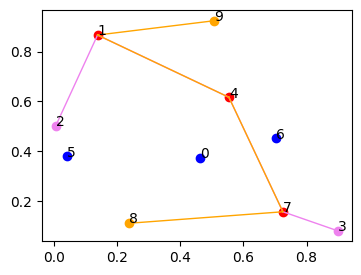

In [311]:
x_opt = np.zeros((C,N,N))
y_opt = np.zeros(N)
for i in range(N):
    y_opt[i] = y[i][0]
    for j in range(N):
        for user_pair in range(C):
            x_opt[user_pair,i,j] = x[user_pair*N**2+i*N+j][0]
# print("x: ", x_opt)
print('y: ', y_opt)

# Gopt = G.copy()
# Gopt = nx.Graph()
# Gopt.add_nodes_from(np.arange(N))
# Gopt= nx.from_numpy_array(x_opt)
plt.figure(figsize=(4,3))
# nx.draw(Gopt, pos, with_labels=True)
for i,y_val in enumerate(y_opt):
    if i not in np.concatenate((s_list,t_list)):
        if y_val == 1:
            plt.plot(pos[i][0],pos[i][1],"ro")#,markersize=5)
            plt.text(pos[i][0],pos[i][1],"%d" % i)
        else:
            plt.plot(pos[i][0],pos[i][1],"bo")
            plt.text(pos[i][0],pos[i][1],"%d" % i)
            
colors = ["violet","orange","gray"]
for user_pair in range(C):
    s = s_list[user_pair]
    plt.plot(pos[s][0],pos[s][1],"o", color = colors[user_pair])
    plt.text(pos[s][0],pos[s][1],"%d" % s)
    t = t_list[user_pair]
    plt.plot(pos[t][0],pos[t][1],"o", color = colors[user_pair])
    plt.text(pos[t][0],pos[t][1],"%d" % t)

    edges = np.argwhere(x_opt[user_pair,:,:]>0)
    path_output = []
    for e in edges:
        if G.has_edge(e[0],e[1]):
            plt.plot([ pos[e[0]][0],pos[e[1]][0] ], [ pos[e[0]][1],pos[e[1]][1] ], color = colors[user_pair], linewidth=1)
            path_output.append(e)
        else:
            path = nx.shortest_path(G, source=e[0], target=e[1], weight="weight")
            path_output.append(path)
            for i in range(len(path)-1):
                e1 = path[i]
                e2 = path[i+1]
                plt.plot([ pos[e1][0],pos[e2][0] ], [ pos[e1][1],pos[e2][1] ], color = colors[user_pair], linewidth=1)
                
    print((s_list[user_pair],t_list[user_pair]),":",path_output)
plt.show()


In [15]:
from gekko import GEKKO
m = GEKKO()
x1 = m.Var(integer=True, lb=0, ub=5) # Product 1
x2 = m.Var(integer=True, lb=0, ub=4) # Product 2
m.Maximize(100*x1+125*x2) # Profit function
m.Equation(3*x1+6*x2<=30) # Units of A
m.Equation(8*x1+4*x2<=44) # Units of B
m.options.SOLVER = 1
m.solve()
p1 = x1.value[0]; p2 = x2.value[0]
print ('Product 1 (x1): ' + str(p1))
print ('Product 2 (x2): ' + str(p2))
print ('Profit        : ' + str(100*p1+125*p2))

apm 67.169.68.205_gk_model8 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            4
   Intermediates:            0
   Connections  :            0
   Equations    :            3
   Residuals    :            3
 
 Number of state variables:              4
 Number of total equations: -            2
 Number of slack variables: -            2
 ---------------------------------------
 Degrees of freedom       :              0
 
 ----------------------------------------------
 Steady State Optimization with APOPT Solver
 ----------------------------------------------
Iter:     1 I:  0 Tm:      0.00 NLPi:    2 Dpth:    0 Lvs:    0 Obj: -7.75E+02 Gap:  0.00E+00
 Successful solution
 
 ------------

## memory

In [395]:
Nmax = 10
Lmax = 0.5
D0 = 2
D = D0*np.ones(N)
s_list = [2] # source
t_list = [3] # destination

C = len(s_list)
R_list = np.array(list(set(node_list)-set(np.concatenate((s_list,t_list)))))

from gekko import GEKKO
m = GEKKO()

w = m.Array(m.Var,C,integer=True,lb=1)
x = m.Array(m.Var,(C,N,N),integer=True,lb=0,ub=1)
y = m.Array(m.Var,N ,integer=True,lb=0,ub=1)

for r in np.concatenate((s_list,t_list)):
    m.Equation( y[r]==0 )

for n1 in R_list:
    n_list = np.array(list(set(R_list)-{n1}))
    sum1_const = 0 
    sum2_const = 0 
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]
        sum1_const += w[user_pair]*(x[user_pair,n1,t] + np.sum(x[user_pair,n1,n_list]))
        sum2_const += w[user_pair]*(x[user_pair,s,n1] + np.sum(x[user_pair,n_list,n1]))
    m.Equation( sum1_const <= D[n1]*y[n1] )
    m.Equation( sum2_const <= D[n1]*y[n1] )

for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]
    m.Equation( nx.shortest_path_length(G, source=s, target=t, weight="weight")*x[user_pair,s,t] <= Lmax)    
    
    number = np.sum(x[user_pair,s,R_list]+ x[user_pair,R_list,t])
    for n1 in R_list:
        m.Equation( x[user_pair,n1,n1] == 0)    
        m.Equation( x[user_pair,n1,s] == 0)    
        m.Equation( x[user_pair,t,n1] == 0)    
        m.Equation( nx.shortest_path_length(G, source=s, target=n1, weight="weight")*x[user_pair,s,n1] <= Lmax)
        m.Equation( nx.shortest_path_length(G, source=n1, target=t, weight="weight")*x[user_pair,n1,t] <= Lmax)        

        for n2 in R_list:
            if n2 != n1:
                m.Equation( nx.shortest_path_length(G, source=n1, target=n2, weight="weight")*x[user_pair,n1,n2] <= Lmax)
                
        n_list = np.array(list(set(R_list)-{n1}))
        m.Equation( x[user_pair,n1,t] - x[user_pair,s,n1] + np.sum(x[user_pair,n1,n_list] - x[user_pair,n_list,n1]) == 0)
        number += np.sum(x[user_pair,n1,n_list])

    m.Equation( number <= Nmax + 1)
    m.Equation( x[user_pair,s,t] + np.sum(x[user_pair,s,R_list]) == 1)
    m.Equation( x[user_pair,s,t] + np.sum(x[user_pair,R_list,t]) == 1)
             
gk = GEKKO()
# # m.Obj(np.sum(y)-np.sum(gk.log(1+w)))
path_prob = m.Array(m.Var,(C,N**2),lb=0)

for user_pair in range(C):
#     path_prob = np.zeros(N**2)
    for n1 in R_list:
        for n2 in R_list:
#             edges = np.argwhere(x[user_pair,:,:]>0)
#             path_prob = []
#             for e in edges:
#             path_prob.append(10**(-2*nx.shortest_path_length(G, source=e[0], target=e[1], weight="weight")/10) )
#             if x[user_pair,n1,n2]>0:
            m.Equation( path_prob[user_pair,n1*N+n2] == x[user_pair,n1,n2]*10**(-0.2*nx.shortest_path_length(G, source=n1, target=n2, weight="weight")/10) )

rate = 0#m.Var(lb=0, ub=1)
for user_pair in range(C):
#     for n1 in R_list:
#         for n2 in R_list:
#             m.Equation(rate == gk.min3(rate,path_prob[user_pair,n1*N+n2]) )
    rate +=  np.sum(path_prob[user_pair,:])
    
# m.Obj(np.sum(y)-np.prod(w)/D0**C)
m.Minimize(np.sum(y)+rate)
m.options.SOLVER = 1
m.solve()

# print('y: ', y)
# x_opt = np.zeros((C,N,N))
x_opt = x[:,:,:][0]
# for i in range(N):
#     for j in range(N):
#         for user_pair in range(C):
#             x_opt[user_pair,i,j] = x[user_pair,i,j][0]
# print("x: ", x_opt)


apm 67.169.68.205_gk_model166 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :          301
   Intermediates:            0
   Connections  :            0
   Equations    :          191
   Residuals    :          191
 
 Number of state variables:            301
 Number of total equations: -          190
 Number of slack variables: -           90
 ---------------------------------------
 Degrees of freedom       :             21
 
 ----------------------------------------------
 Steady State Optimization with APOPT Solver
 ----------------------------------------------
Iter:     1 I:  0 Tm:      0.02 NLPi:    4 Dpth:    0 Lvs:    3 Obj:  2.51E-01 Gap:       NaN
Iter:     2 I: -1 Tm:      0.00 NL

Iter:    84 I:  0 Tm:      0.01 NLPi:    4 Dpth:   15 Lvs:   30 Obj:  2.06E+00 Gap:       NaN
Iter:    85 I:  0 Tm:      0.01 NLPi:    3 Dpth:   15 Lvs:   32 Obj:  1.98E+00 Gap:       NaN
Iter:    86 I: -1 Tm:      0.01 NLPi:    2 Dpth:   16 Lvs:   31 Obj:  1.98E+00 Gap:       NaN
Iter:    87 I:  0 Tm:      0.01 NLPi:    4 Dpth:   16 Lvs:   33 Obj:  2.63E+00 Gap:       NaN
Iter:    88 I:  0 Tm:      0.01 NLPi:    3 Dpth:   16 Lvs:   35 Obj:  1.98E+00 Gap:       NaN
Iter:    89 I: -1 Tm:      0.01 NLPi:    2 Dpth:   17 Lvs:   34 Obj:  1.98E+00 Gap:       NaN
Iter:    90 I:  0 Tm:      0.01 NLPi:    3 Dpth:   17 Lvs:   36 Obj:  3.26E+00 Gap:       NaN
Iter:    91 I:  0 Tm:      0.01 NLPi:    4 Dpth:   17 Lvs:   38 Obj:  1.99E+00 Gap:       NaN
Iter:    92 I: -1 Tm:      0.01 NLPi:    2 Dpth:   18 Lvs:   37 Obj:  1.99E+00 Gap:       NaN
Iter:    93 I: -1 Tm:      0.01 NLPi:    3 Dpth:   18 Lvs:   36 Obj:  1.99E+00 Gap:       NaN
Iter:    94 I:  0 Tm:      0.01 NLPi:    3 Dpth:   18 Lvs:  

In [397]:
print(path_prob)

[[[0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0]
  [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0]
  [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0]
  [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0]
  [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0]
  [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0]
  [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0]
  [0.0] [0.0] [0.0] [0.97772156232] [0.0] [0.0] [0.0] [0.0] [0.0] [0.0]
  [0.0] [0.0] [0.0] [0.0] [0.0] [0.0]]]


[[2.0]]
(2, 3) : [array([2, 8]), array([7, 3]), array([8, 7])]


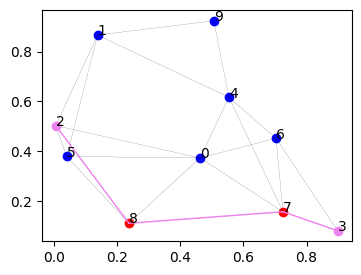

In [396]:
print(w)
x_opt = np.zeros((C,N,N))
y_opt = np.zeros(N)
for i in range(N):
    y_opt[i] = y[i][0]
    for j in range(N):
        for user_pair in range(C):
            x_opt[user_pair,i,j] = x[user_pair,i,j][0]
# # print("x: ", x_opt)
# # print('y: ', y_opt)

# Gopt = G.copy()
# Gopt = nx.Graph()
# Gopt.add_nodes_from(np.arange(N))
# Gopt= nx.from_numpy_array(x_opt)
plt.figure(figsize=(4,3))
# nx.draw(Gopt, pos, with_labels=True)
for i,y_val in enumerate(y_opt):
    if i not in np.concatenate((s_list,t_list)):
        if y_val == 1:
            plt.plot(pos[i][0],pos[i][1],"ro")#,markersize=5)
            plt.text(pos[i][0],pos[i][1],"%d" % i)
        else:
            plt.plot(pos[i][0],pos[i][1],"bo")
            plt.text(pos[i][0],pos[i][1],"%d" % i)
            
for e in G.edges():
    plt.plot([ pos[e[0]][0],pos[e[1]][0] ], [ pos[e[0]][1],pos[e[1]][1] ], color = "black", linewidth=0.1)

colors = ["violet","orange","gray"]
for user_pair in range(C):
    s = s_list[user_pair]
    plt.plot(pos[s][0],pos[s][1],"o", color = colors[user_pair])
    plt.text(pos[s][0],pos[s][1],"%d" % s)
    t = t_list[user_pair]
    plt.plot(pos[t][0],pos[t][1],"o", color = colors[user_pair])
    plt.text(pos[t][0],pos[t][1],"%d" % t)

    edges = np.argwhere(x_opt[user_pair,:,:]>0)
    path_output = []
    for e in edges:
        if G.has_edge(e[0],e[1]):
            plt.plot([ pos[e[0]][0],pos[e[1]][0] ], [ pos[e[0]][1],pos[e[1]][1] ], color = colors[user_pair], linewidth=1)
            path_output.append(e)
        else:
            path = nx.shortest_path(G, source=e[0], target=e[1], weight="weight")
            path_output.append(path)
            for i in range(len(path)-1):
                e1 = path[i]
                e2 = path[i+1]
                plt.plot([ pos[e1][0],pos[e2][0] ], [ pos[e1][1],pos[e2][1] ], color = colors[user_pair], linewidth=1)
                
    print((s_list[user_pair],t_list[user_pair]),":",path_output)
plt.show()

In [358]:
from math import *
def ent_rate_memory_exact(p_list,W):
#     N = len(p_list) # number of links (or number of repeaters -1)
#     Q = np.zeros((W,N)) 
#     for k, p_k in enumerate(p_list):
#         for i in range(W):
#             Q[i,k] = comb(W,i+1)* p_k**(i+1) * (1-p_k)**(W-i-1)

#     P = np.zeros((W,N)) 
#     P[:,0] = Q[:,0]     
#     for k in range(1,N):
#         for i in range(W):
#             P[i,k] = P[i,k-1]* np.sum(Q[i:,k]) + Q[i,k]* np.sum(P[i+1:,k-1])

#     return np.sum(np.arange(1,W+1)*P[:,N-1])
    print("W: ", W)
    print("pl: ", np.min(np.array(p_list)))
    return W*np.min(np.array(p_list))

# edges = np.argwhere(x_opt[user_pair,:,:]>0)
# path_prob = []
# for e in edges:
#     path_prob.append(10**(-2*nx.shortest_path_length(G, source=e[0], target=e[1], weight="weight")/10) )
# print(edges)
# print(path_prob)
# print(ent_rate_memory_exact(path_prob,2))


## scipy opimizer

In [123]:
cons = []
for n1 in R_list:
    def y_const(x):
        n2 = np.array(list(set(R_list)-{n1}))
        sum_const = 0 
        for user_pair in range(C):
            s = s_list[user_pair]
            t = t_list[user_pair]
            sum_const += x[user_pair*N**2+n1*N+t] + np.sum(x[user_pair*N**2+n1*N+n2])
        return D[n1]*x[C*N**2+n1]  - sum_const
    cons.append({'type': 'ineq','fun': lambda x: y_const(x) })
    def y_const(x):
        n2 = np.array(list(set(R_list)-{n1}))
        sum_const = 0 
        for user_pair in range(C):
            s = s_list[user_pair]
            t = t_list[user_pair]
            sum_const += x[user_pair*N**2+s*N+n1] + np.sum(x[user_pair*N**2+n2*N+n1])
        return D[n1]*x[C*N**2+n1]  - sum_const
    cons.append({'type': 'ineq','fun': lambda x: y_const(x) })

for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]
    
    def number_const(x):
        number = np.sum(x[user_pair*N**2+s*N+R_list]+ x[user_pair*N**2+R_list*N+t])
        for n1 in R_list:
            n2 = np.array(list(set(R_list)-{n1}))
            number += np.sum(x[user_pair*N**2+n1*N+n2])
        return number
    cons.append({'type': 'ineq','fun': lambda x: Nmax + 1- number_const(x) })

    def path_s_const(x):
        path_s = x[user_pair*N**2+s*N+t]
        return path_s + np.sum(x[user_pair*N**2+s*N+R_list])
    cons.append({'type': 'ineq','fun': lambda x: 1- path_s_const(x) })
    cons.append({'type': 'ineq','fun': lambda x: path_s_const(x)-1 })
    
    def path_t_const(x):
        path_t = x[user_pair*N**2+s*N+t]
        return path_t + np.sum(x[user_pair*N**2+R_list*N+t])
    cons.append({'type': 'ineq','fun': lambda x: 1- path_t_const(x) })
    cons.append({'type': 'ineq','fun': lambda x: path_t_const(x)-1 })

    cons.append({'type': 'ineq','fun': lambda x:  Lmax - nx.shortest_path_length(G, source=s, target=t, weight="weight")*x[user_pair*N**2+s*N+t]}) 

    for n1 in R_list:
        cons.append({'type': 'ineq','fun': lambda x:  Lmax - nx.shortest_path_length(G, source=s, target=n1, weight="weight")*x[user_pair*N**2+s*N+n1]}) 
        cons.append({'type': 'ineq','fun': lambda x:  Lmax - nx.shortest_path_length(G, source=n1, target=t, weight="weight")*x[user_pair*N**2+n1*N+t]})
        
        def path_const(x):
            path = x[user_pair*N**2+n1*N+t] - x[user_pair*N**2+s*N+n1]
            n2 = np.array(list(set(R_list)-{n1}))
            return path + np.sum(x[user_pair*N**2+n1*N+n2] - x[user_pair*N**2+n2*N+n1])
        cons.append({'type': 'ineq','fun': lambda x: path_const(x) })
        cons.append({'type': 'ineq','fun': lambda x: -path_const(x) })

        for n2 in R_list:
            if n2 != n1:
                cons.append({'type': 'ineq','fun': lambda x:  Lmax - nx.shortest_path_length(G, source=n1, target=n2, weight="weight")*x[user_pair*N**2+n1*N+n2]})
            cons.append({'type': 'ineq','fun': lambda x:  x[user_pair*N**2+n1*N+n2]})
            cons.append({'type': 'ineq','fun': lambda x:  1-x[user_pair*N**2+n1*N+n2]})
                
for n1 in R_list:
    cons.append({'type': 'ineq','fun': lambda x:  x[C*N**2+n1]})
    cons.append({'type': 'ineq','fun': lambda x:  1-x[C*N**2+n1]})

def objective(x):
    return (np.sum(x[C*N**2+R_list]))**2

bnds = []
for j in range(x_size):
    bnds.append((0,1))  

ops = {'maxiter': 1000}
f = sp.optimize.minimize(objective, x0,options=ops, bounds=bnds, constraints=cons, method='COBYLA')
print(f)


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 5.674959419196365e-09
       x: [-1.181e-02  1.228e+00 ... -7.116e-19 -1.140e+00]
    nfev: 250
   maxcv: 2.220446049250313e-16


In [125]:
# print(objective(x0))
# print(number_const(x0))
# print(path_s_const(x0))
# print(path_t_const(x0))
# print(path_s_const(x0))

print(objective(f.x),objective(x0))
# print(f.x[:4])
# print(np.round(f.x))
print(number_const(f.x),number_const(x0))
print(path_s_const(f.x),path_s_const(x0))
print(path_t_const(f.x),path_t_const(x0))
# for n1 in R_list:
#     def path_const(x):
#         path = x[user_pair*N**2+n1*N+t] - x[user_pair*N**2+s*N+n1]
#         n2 = np.array(list(set(R_list)-{n1}))
#         return path + np.sum(x[user_pair*N**2+n1*N+n2] - x[user_pair*N**2+n2*N+n1])
#     print(path_const(f.x))
for n1 in R_list:
    def y_const(x):
        n2 = np.array(list(set(R_list)-{n1}))
        sum_const = 0 
        for user_pair in range(C):
            s = s_list[user_pair]
            t = t_list[user_pair]
            sum_const += x[user_pair*N**2+n1*N+t] + np.sum(x[user_pair*N**2+n1*N+n2])
        return D[n1]*x[C*N**2+n1]  - sum_const
    print(y_const(f.x),y_const(x0))
    def y_const(x):
        n2 = np.array(list(set(R_list)-{n1}))
        sum_const = 0 
        for user_pair in range(C):
            s = s_list[user_pair]
            t = t_list[user_pair]
            sum_const += x[user_pair*N**2+s*N+n1] + np.sum(x[user_pair*N**2+n2*N+n1])
        return D[n1]*x[C*N**2+n1]  - sum_const
    print(y_const(f.x),y_const(x0))

# x_opt = np.zeros((C,N,N))
# y_opt = np.zeros(N)
# for i in range(N):
#     y_opt[i] = x0[C*N**2+i]
#     for j in range(N):
#         for user_pair in range(C):
#             x_opt[user_pair,i,j] = x0[user_pair*N**2+i*N+j]
# print(np.round(x_opt))
# print(np.round(y_opt))

x_opt = np.zeros((C,N,N))
y_opt = np.zeros(N)
for i in range(N):
    y_opt[i] = f.x[C*N**2+i]
    for j in range(N):
        for user_pair in range(C):
            x_opt[user_pair,i,j] = f.x[user_pair*N**2+i*N+j]
print((x_opt))
print((y_opt))


5.674959419196365e-09 4.0
1.536461529446905 3.0
1.0000000000000002 1.0
0.9999999999999998 1.0
-0.5066543314070411 0.0
-0.5066543314070416 0.0
0.06879170023762426 0.0
0.06879170023762446 0.0
[[[-0.01180547  1.22796568 -0.12929145 -0.09867423]
  [-0.40472355 -0.66365308  0.06049975  0.44607925]
  [-0.11421616 -0.72138668  0.84769161  0.65259498]
  [-0.60497784  0.15411387  0.66890186 -0.4525304 ]]]
[-5.32241242e-01 -7.53323265e-05 -7.11583570e-19 -1.14024677e+00]


In [26]:
from scipy.optimize import fsolve, fmin_cobyla, fmin
import scipy as sp

def objective(x):
    return x[0]*x[1]

def constr1(x):
    return 1 - (x[0]**2 + x[1]**2)

def constr2(x):
    return x[1]-0.9

def constr3(x):
    return 0.9-x[1]

cons = []
# cons.append({'type': 'ineq','fun': lambda x: 1 - (x[0]**2 + x[1]**2)})
cons.append({'type': 'ineq','fun': lambda x: constr1(x)})

# f = fmin_cobyla(objective, [0.0, 0.1], cons, rhoend=1e-7)
f = sp.optimize.minimize(objective, [0.0, 0.1],constraints=cons,method='COBYLA')
print(f)
            
            

SyntaxError: invalid syntax (400122842.py, line 18)

In [96]:
Nmax = 10
Lmax = 0.4
D0 = 1
D = D0*np.ones(N)
s_list = [13,10]#,0,6]# source
t_list = [3,9]#,11,8] # destination

C = len(s_list)

# indices: (superscript, subscript)
m = Model()
# x_size = R**2 + R + 1
# y_size = R**2 + R + 1
x = m.addMVar((C,N,N), vtype=GRB.BINARY,name="x")
yu = m.addMVar((N), vtype=GRB.BINARY,name="yu")

R_list = np.array(list(set(node_list)-set(np.concatenate((s_list,t_list)))))

for user_pair in range(C):
    s = s_list[user_pair]
    t = t_list[user_pair]
    
#     R_list = list(set(node_list)-{s,t})
#     R = len(R_list)
#     y_sum = 0
    number = 0
    path_s = x[user_pair][s][t]
    path_t = x[user_pair][s][t]
    for n1 in R_list:
        m.addConstr( nx.shortest_path_length(G, source=s, target=n1, weight="weight")*x[user_pair][s][n1] <= Lmax ) 
        m.addConstr( nx.shortest_path_length(G, source=n1, target=t, weight="weight")*x[user_pair][n1][t] <= Lmax ) 
#         y_sum += yu[n1]
#         y_const = x[user_pair][n1][t]
        path = x[user_pair][n1][t] - x[user_pair][s][n1]
        number += x[user_pair][s][n1]+ x[user_pair][n1][t]
        path_s += x[user_pair][s][n1]
        path_t += x[user_pair][n1][t]
        for n2 in R_list:
            if n2 != n1:
                m.addConstr( nx.shortest_path_length(G, source=n1, target=n2, weight="weight")*x[user_pair][n1][n2] <= Lmax ) 
                path += x[user_pair][n1][n2] - x[user_pair][n2][n1]
                number += x[user_pair][n1][n2]
#                 y_const += x[user_pair][n1][n2]

#         m.addConstr( y_const <= D[n1]*yu[n1] ) 
        m.addConstr( path == 0 ) 
    m.addConstr( number <= Nmax + 1 ) 
    m.addConstr( path_s == 1 )
    m.addConstr( path_t == 1 )
    m.addConstr( nx.shortest_path_length(G, source=s, target=t, weight="weight")*x[user_pair][s][t] <= Lmax ) 

# R_list = list(set(node_list)-set(np.concatenate((s_list,t_list))))

# y_const = np.zeros(len(R_list))
    
for n1 in R_list:
    y_const = 0
    for user_pair in range(C):
        s = s_list[user_pair]
        t = t_list[user_pair]
        y_const += x[user_pair][n1][t]
        for n2 in R_list:
            if n2 != n1:
                y_const += x[user_pair][n1][n2]

    m.addConstr( y_const <= D[n1]*yu[n1] ) 


y_sum = 0
for n1 in range(N):
    if (n1 not in s_list) and (n1 not in t_list):
        y_sum += yu[n1]

m.setObjective(y_sum , GRB.MINIMIZE)
m.optimize()

x_opt = np.zeros((C,N,N))
y_opt = np.zeros(N)
for i in range(N):
    if m.getVars()[len(s_list)*N**2+i].X > 0:
        y_opt[i] = m.getVars()[len(s_list)*N**2+i].X
    for j in range(N):
        for user_pair in range(C):
            if m.getVars()[user_pair*N**2+i*N+j].X > 0:
                x_opt[user_pair,i,j] = m.getVars()[user_pair*N**2+i*N+j].X

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 258 rows, 406 columns and 1096 nonzeros
Model fingerprint: 0xafbb6beb
Variable types: 0 continuous, 406 integer (406 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-01, 1e+01]
Presolve removed 225 rows and 348 columns
Presolve time: 0.00s
Presolved: 33 rows, 58 columns, 217 nonzeros
Variable types: 0 continuous, 58 integer (58 binary)
Found heuristic solution: objective 7.0000000
Found heuristic solution: objective 6.0000000

Root relaxation: cutoff, 20 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutof

(13, 3) : [array([ 4, 11]), array([8, 4]), array([11,  3]), array([13,  8])]
(10, 9) : [array([0, 9]), array([1, 0]), array([5, 1]), array([10,  5])]


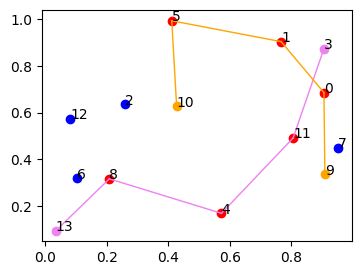

In [97]:
# Gopt = G.copy()
# Gopt = nx.Graph()
# Gopt.add_nodes_from(np.arange(N))
# Gopt= nx.from_numpy_array(x_opt)
plt.figure(figsize=(4,3))
# nx.draw(Gopt, pos, with_labels=True)
for i,y in enumerate(y_opt):
    if i not in np.concatenate((s_list,t_list)):
        if y == 1:
            plt.plot(pos[i][0],pos[i][1],"ro")#,markersize=5)
            plt.text(pos[i][0],pos[i][1],"%d" % i)
        else:
            plt.plot(pos[i][0],pos[i][1],"bo")
            plt.text(pos[i][0],pos[i][1],"%d" % i)
            
colors = ["violet","orange","gray"]
for user_pair in range(C):
    s = s_list[user_pair]
    plt.plot(pos[s][0],pos[s][1],"o", color = colors[user_pair])
    plt.text(pos[s][0],pos[s][1],"%d" % s)
    t = t_list[user_pair]
    plt.plot(pos[t][0],pos[t][1],"o", color = colors[user_pair])
    plt.text(pos[t][0],pos[t][1],"%d" % t)

    edges = np.argwhere(x_opt[user_pair,:,:]>0)
    path_output = []
    for e in edges:
        if G.has_edge(e[0],e[1]):
            plt.plot([ pos[e[0]][0],pos[e[1]][0] ], [ pos[e[0]][1],pos[e[1]][1] ], color = colors[user_pair], linewidth=1)
            path_output.append(e)
        else:
            path = nx.shortest_path(G, source=e[0], target=e[1], weight="weight")
            path_output.append(path)
            for i in range(len(path)-1):
                e1 = path[i]
                e2 = path[i+1]
                plt.plot([ pos[e1][0],pos[e2][0] ], [ pos[e1][1],pos[e2][1] ], color = colors[user_pair], linewidth=1)
                
    print((s_list[user_pair],t_list[user_pair]),":",path_output)
plt.show()


In [ ]:
def ent_rate_memory_exact(p_list,W):
    N = len(p_list) # number of links (or number of repeaters -1)
    Q = np.zeros((W,N)) 
    for k, p_k in enumerate(p_list):
        for i in range(W):
            Q[i,k] = comb(W,i+1)* p_k**(i+1) * (1-p_k)**(W-i-1)

    P = np.zeros((W,N)) 
    P[:,0] = Q[:,0]     
    for k in range(1,N):
        for i in range(W):
            P[i,k] = P[i,k-1]* np.sum(Q[i:,k]) + Q[i,k]* np.sum(P[i+1:,k-1])

    return np.sum(np.arange(1,W+1)*P[:,N-1])



In [ ]:
from gekko import GEKKO
# m=GEKKO()
# p=m.Param(1.2)
# x=m.Array(m.Var,3,integer=True,lb=1,ub=5)
# eq0 = x[1]==x[0]+p
# eq1 = x[2]-1==x[1]+x[0]
# m.Equation(x[2]==x[1]**2)
# m.Equations([eq0,eq1])
# m.solve()
# for i in range(3):
#    print('x['+str(i)+']='+str(x[i].value))
m = GEKKO()
n = 10
# select one of the Special Ordered Set
α = m.sos1([0.5, 1, 2, 5])
# integer variables
β = m.Array(m.Var,n,integer=True,lb=1,ub=5)
# log transform
δ = [m.log(b) for b in β] 
# matrix
M = np.random.rand(n,n)
# constraints
Mδ = M.dot(δ)
m.Equations([α*x>10 for x in Mδ])
# objective
m.Minimize(α)
# solve
m.solve()
print('α: ', α.value[0])
print('β: ', β)